# Chapter 1.5 - Optimal Control

** Contributors: James Jackson **

### Table of Contents

 1. [Introduction](#Introduction)
 1. [Linear-Quadratic Control](#Linear-Quadratic-Control)
 1. [Error State Parameterization](#Error-State-Parameterization)
   1. [Kinematics Revisited from a Manifold Perspective](#Kinematics-Revisited-from-a-Manifold-Perspective)
   1. [Definition](#Error-State-Defintion)
   1. [Dynamics](#Error-State-Dynamics)
   1. [Jacobians](#Error-State-Jacobians)
 1. [LQR On Manifold Example](#LQR-On-Manifold-Example)
   1. [LQR with Input Saturation](#LQR-with-Input-Saturation)
 1. [Linear Model Predictive Control Example](#Linear-Model-Predictive-Control)

## Introduction

In general, optimal control seeks to minimize the continuous-time cost function
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\u}{\mathbf{u}}$
$\newcommand{\b}{\mathbf{b}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

\begin{eqnarray}
J = \h\lp\x(t_0), \x(t_f)\rp + \int_{t_0}^{t_f} \mathcal{L}\lp\x(t), \u(t)\rp dt
\label{eq:cost_function}
\end{eqnarray}

subject to dynamic constraints

\begin{eqnarray}
\dot{\mathbf{x}}(t) = f\left(\x(t), \u(t)\right),
\label{eq:dynamic_constraints}
\end{eqnarray}

algebraic _path constraints_
\begin{eqnarray}
\b\lp \x(t) \u(t) \rp \leq 0,
\label{eq:path_constraints}
\end{eqnarray}

and boundary conditions
\begin{eqnarray}
\h\lp \x(t_0), \x(t_f) \rp = 0
\label{eq:boundary_conditions}
\end{eqnarray}

where $\x(t)$ is the state, $\u(t)$ is the input, and $t$ is time with $t_0$ being the initial time, and $t_f$ the final time. $\h$ is known as the _endpoint cost_ and $\mathcal{L}$ is known as the _Lagrangian._  In many cases, $\b$ is given an inequality constraint, and therefore may not be zeros at the optimal solution, and there are sometimes many solutions to the above problem, therefore optimal control is known to be locally minimizing.

### Linear-Quadratic Control

A special case of quadratic control is the Linear Quadratic Regulator (LQR).  In this case, the cost function \eqref{eq:cost_function} is defined as the following infinite-horizon quadratic expression
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\Q}{\mathbf{Q}}$
$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\A}{\mathbf{A}}$
$\newcommand{\B}{\mathbf{B}}$
$\newcommand{\K}{\mathbf{K}}$

\begin{eqnarray}
J = \frac{1}{2} \int_0^{\infty}\lp \x^\top (t) \Q \x(t) + \u^\top(t)\R\u(t) \rp dt
\label{eq:LQR_cost}
\end{eqnarray}

subject to the linear, time-invariant first-order dynamic constraints

\begin{eqnarray}
\dot{\x}(t) = \A\x(t) + \B\u(t),
\end{eqnarray}

and the initial condition
\begin{eqnarray}
\x(t_0) = \x_0
\end{eqnarray}

where $\x(\infty) = 0$.

It has been shown that this problem can be solved with 

\begin{eqnarray}
\u(t) = -\K(t)\x(t)
\end{eqnarray}

where
\begin{eqnarray}
\K(t) = \R^{-1}\B^\top\S(t),
\end{eqnarray}

and $\S(t)$ is the solution to the algebraic Riccati equation (ARE) given as
\begin{eqnarray}
0 = -\S\A - \A^\top \S + \S\B\R^{-1}\B^\top\S-\Q
\end{eqnarray}

and can be solved for efficiently using modern scientific compution libraries such as `scipy` as shown below. As a side node, the LQR problem was originally solved by Rudolf Kalman [(_Kalman, 1960_)](https://www.cs.unc.edu/~welch/kalman/media/pdf/Kalman1960.pdf).

In [1]:
import numpy as np
from scipy.linalg import solve_continuous_are, inv
def lqr(A,B,Q,R):
    #first, try to solve the ricatti equation
    X = np.matrix(solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(inv(R)*(B.T*X))
    return K

## Error State Parameterization
$\newcommand{\xr}{\x^c}$
$\newcommand{\xt}{\tilde{\x}}$
$\newcommand{\ur}{\u^c}$
$\newcommand{\ut}{\tilde{\u}}$

Many optimal control formulations (such as LQR) assume that the state $\x$ is a vector, and therefore are not natively adapted to work on the $SO(2)$ manifold.  As such, we must perform control on the _error space_ between some reference trajectory and our current state.  This has the side benefit of formulating our problem as a _regulation_ type problem, which makes it well suited for LQR.

### Kinematics Revisited from a Manifold Perspective

Before we dig into the error state definition, we need to formalize some more manifold machinery.  Let us revisit they kinematics of $S1$, but using a limit over the tangent space.  Let us consider $G$ as the rotation from some fixed frame $a$ to some rotating frame $b(t)$, rotating at some rate $\omega(t)$.  

$\newcommand{lp}{\left(}$
$\newcommand{rp}{\right)}$

\begin{eqnarray}
\frac{d}{dt}G_a^{b(t)} &=& \lim_{\Delta t \to 0} \frac{1}{\Delta t} \lp \log\lp G_{a}^{b(t + \Delta t)} \circ G_{a}^{b(t),-1} \rp \rp \\
&=& \lim_{\Delta t \to 0} \frac{1}{\Delta t} \lp 
\log\lp\exp\lp\delta_{b(t)}^{b(t + \Delta t)}\rp \circ G_{a}^{b(t)} \circ G_{a}^{b(t),-1} \rp 
\rp \\
&=& \lim_{\Delta t \to 0} \frac{1}{\Delta t} \lp \log\lp\exp\lp\delta_{b(t)}^{b(t + \Delta t)}\rp \rp \rp \\
&=& \lim_{\Delta t \to 0} \frac{1}{\Delta t} \lp \Delta t \omega_{b(t)/a}^{b(t)} \rp \\
&=& \omega_{a}^{b(t)}
\end{eqnarray}

#### Error State Defintion

As before, our state $\x$ is defined as the tuple of the system's current position along the unit circle, expressed as a member of $SO(2)$ and the angular rate $\omega$

\begin{eqnarray}
\x = \begin{pmatrix} \Phi & \omega \end{pmatrix}^\top \;,
\end{eqnarray}

the input $\u$ is defined as the applied torque to the system $\tau$

\begin{eqnarray}
\u = \tau \;.
\end{eqnarray}

The dynamics of the system are

\begin{aligned}
\dot{\Phi} &= \omega \\
\dot{\omega} &= -\frac{b}{I} \omega + \frac{1}{I} \tau \;.
\end{aligned}

such that euler integration (assuming $\omega$ is constant over the interval $\Delta t$) is performed as

\begin{aligned}
\Phi(t + \Delta t) &= \Phi(t) \boxplus \Delta t \omega \\
\omega(t + \Delta t) &= \omega(t) + \lp\frac{1}{I} \tau - \frac{b}{I} \omega\rp\Delta t \;,
\end{aligned}

and where $\boxplus$ is defined as

\begin{aligned}
\Phi(t + \Delta t) &= \Phi(t) \boxplus \Delta t \omega \\
&= \exp(\omega \Delta t) \Phi(t) \; .
\end{aligned}

Let us define the error state, $\xt$ between our current state $\x$ and desired state $\xr$ as follows:

\begin{aligned}
\begin{pmatrix} \tilde{\Phi} \\ \tilde{\omega} \end{pmatrix} &= \begin{pmatrix} \log\lp \Phi^c \circ \Phi^{-1} \rp^\vee \\ \omega - \omega^c \end{pmatrix} \\
    \xt &= \x \boxminus \xr \;,
\end{aligned}

where the $\boxminus$ operator is defined to encapsulate the notion of "differencing" our desired and current state.  Similarly to when we calculated error $e$ in the definition of PID control, $\tilde{\Phi}\in\mathfrak{so}^\vee\cong \mathbb{R}^1$, which means that $\xt\in\mathbb{R}^2$.

We also must define our error state input, which is trivially defined as
\begin{aligned}
\ut = \u - \ur \;.
\end{aligned}



### Error-State Dynamics

Since we are performing control on the error state directly, we must find an expression for the error state dynamics.  Let's start with the definition of the error state:

\begin{aligned}
\xt &= \x \boxminus \xr
\end{aligned}

Taking the time derivative of both side leads to
$\newcommand{ddt}{\frac{d}{dt}}$
$\newcommand{ddP}{\frac{d}{d\Phi}}$
$\newcommand{ddPc}{\frac{d}{d\Phi^c}}$
$\newcommand{atan}{\textrm{atan}}$

\begin{eqnarray}
\dot{\xt} &= \dot{\x} - \dot{\xr}
\end{eqnarray}

The $\boxminus$ goes away because $\dot{\xt}$, $\dot{\x}$ and $\dot{\xr}$ are all in $\mathbb{R}^1$, and therefore can be differenced using the normal subtraction operator.

So, let us write out these dynamics in terms of their actual values

\begin{eqnarray}
\dot{\xt} &=& \dot{\x} - \dot{\xr} \nonumber\\
\begin{pmatrix} \dot{\tilde{\Phi}} \\ \dot{\tilde{\omega}} \end{pmatrix} 
&=& \begin{pmatrix} \omega - \omega^c \\ -\frac{b}{I} \omega + \frac{1}{I} \tau - -\frac{b}{I} \omega^c + \frac{1}{I} \tau^c \end{pmatrix} \nonumber\\ 
&=& \begin{pmatrix} \omega - \omega^c \\ \frac{b}{I}\lp\omega^c - \omega \rp + \frac{1}{I}\lp \tau - \tau^c \rp \end{pmatrix} \label{eq:error_state_dynamics}
\end{eqnarray}
We now need to write our dynamics in terms of only the current state and the error state - this will allow us to linearize our system about the error state.  To do this, first we must describe the desired state in terms of the current state and the error state

\begin{eqnarray}
\begin{pmatrix} \tilde{\Phi} \\ \tilde{\omega} \end{pmatrix} &=& \begin{pmatrix} \log\lp \Phi^c \circ \Phi^{-1} \rp^\vee \\ \omega - \omega^c \end{pmatrix} \nonumber \\
\begin{pmatrix} \exp\lp\tilde{\Phi^\wedge}\rp \\ \tilde{\omega} \end{pmatrix} &=& \begin{pmatrix} \Phi^c \circ \Phi^{-1} \\ \omega - \omega^c \end{pmatrix} \nonumber \\
\begin{pmatrix} \exp\lp\tilde{\Phi^\wedge}\rp\circ\Phi \\ \omega - \tilde{\omega} \end{pmatrix} &=& \begin{pmatrix} \Phi^c \\  \omega^c \end{pmatrix} \label{eq:des_as_error_and_current}
\end{eqnarray}

Lets now plug \eqref{eq:des_as_error_and_current} into \eqref{eq:error_state_dynamics}

\begin{eqnarray}
\begin{pmatrix} \dot{\tilde{\Phi}} \\ \dot{\tilde{\omega}} \end{pmatrix} 
&=& \begin{pmatrix} \omega - \lp\omega - \tilde{\omega}\rp \\ \frac{b}{I}\lp \lp \omega - \tilde{\omega} \rp - \omega \rp + \frac{1}{I}\lp \tau - \lp\tau - \tilde{\tau} \rp \rp \end{pmatrix} \nonumber \\
&=& \begin{pmatrix} \tilde{\omega} \\ -\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau} \end{pmatrix} \label{eq:final_error_state_dynamics}\\
\end{eqnarray}

### Error-State Jacobians

And now it is straight-forward to calculate our state and input Jacobians.  First let us calculate the partial derivative of our dynamics \eqref{eq:final_error_state_dynamics} with respect to our state.
$\newcommand{dd}[1]{\frac{\partial}{\partial #1}}$
\begin{eqnarray}
\dd{\x}f\lp\x,\u\rp &=& \dd{\x} \begin{pmatrix} \tilde{\omega} \\ -\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau} \end{pmatrix} \nonumber \\
&=& 
\begin{pmatrix} 
    \dd{\tilde{\Phi}} \tilde{\omega} & \dd{\tilde\omega} \tilde{\omega}  \\
    \dd{\tilde{\Phi}} \lp-\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau}\rp  & \dd{\tilde{\omega}}\lp -\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau}\rp
\end{pmatrix} \nonumber \\
\A &=& 
\begin{pmatrix} 
    0 & 1  \\
    0 & -\frac{b}{I}
\end{pmatrix} \nonumber \\
\end{eqnarray}

Next, we will calculate the partial derivative of the dynamics with respect to the input
\begin{eqnarray}
\dd{\u}f\lp\x,\u\rp &=& \dd{\u} \begin{pmatrix} \tilde{\omega} \\ -\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau} \end{pmatrix} \nonumber \\
&=& 
\begin{pmatrix} 
    \dd{\tilde{\tau}} \tilde{\omega} \\
    \dd{\tilde{\tau}} \lp-\frac{b}{I}\tilde{\omega}+ \frac{1}{I}\tilde{\tau}\rp
\end{pmatrix} \nonumber \\
\B &=& 
\begin{pmatrix} 
    0 \\
    \frac{1}{I}
\end{pmatrix} \nonumber \\
\end{eqnarray}

This now forms the linearized system

$$
\dot{\xt} \approx \A \xt + \B \ut
$$

## LQR On Manifold Example

Now that we have a linearized system, we can perform LQR control.  Below is an LQR controller using this system

In [2]:
# %load files/so2.py
import numpy as np

class SO2:
    def __init__(self, G=np.eye(2)):
        self.mat = G

    def dot(self, rhs):
        return SO2(np.dot(self.mat, rhs.mat))

    @staticmethod
    def identity():
        return SO2(np.eye(2))

    def inverse(self):
        return SO2(self.mat.T)

    @staticmethod
    def exp(g):
        omega = SO2.vee(g)
        return SO2(np.array([[np.cos(omega), -np.sin(omega)], [np.sin(omega), np.cos(omega)]]))

    def log(self):
        theta = self.to_angle()
        return np.array([[0, -theta], [theta, 0]])

    @staticmethod
    def hat(omega):
        return np.array([[0.0, -omega],[omega, 0.0]])

    @staticmethod
    def vee(g):
        return g[1,0]

    def to_angle(self):
        return np.arctan2(self.mat[1,0], self.mat[0,0])

    @staticmethod
    def from_angle(theta):
        return SO2.exp(SO2.hat(theta))

    def visualize(self):
        pos = self.mat.dot(np.array([1.0, 0]))
        return pos[0], pos[1]

    def __str__(self):
        return self.mat.__str__()
    
    def __repr__(self):
        return self.mat.__str__()

In [3]:
# %load files/simulator.py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

class Simulator:
    def __init__(self, controller, commands=[0.0], command_duration=5.0):
        self.controller = controller

        # time
        self.dt = 0.01
        self.t = np.arange(0.0, command_duration*len(commands), self.dt)

        # system parameters
        self.I = 1.0
        self.b = 0.1

        # system state
        self.Phi = SO2()
        self.omega = 0.0

        # commands
        self.theta_c = np.zeros(self.t.shape)
        for i in range(len(commands)):
            self.theta_c[i*self.t.size//len(commands):(i+1)*self.t.size//len(commands)] = commands[i]

        # history
        self.theta_hist = np.zeros(self.t.shape)
        self.omega_hist = np.zeros(self.t.shape)
        self.tau_hist = np.zeros(self.t.shape)

    def animate(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal', xlim=[-1.2, 1.2], ylim=[-1.2,1.2])
        ax.axis('off')
        ax.set_title(self.controller.name)

        th = np.linspace(0, 2*np.pi, 100)
        ax.plot(np.cos(th), np.sin(th), 'k-')

        self.command_line = ax.plot([], [], 'ro', label='command')[0]
        self.actual_line = ax.plot([], [], 'bo', label='actual')[0]
        ax.legend(loc='center', numpoints=1)

        return animation.FuncAnimation(fig, self.step, frames=len(self.t), interval=int(1000*self.dt), blit=False, repeat=False)

    def step(self, k):
        # if the controller uses a manifold representation, convert the command to an element of SO(2)
        if self.controller.manifold:
            tau = self.controller.run(SO2.from_angle(self.theta_c[k]), self.Phi, self.omega)
        else:
            tau = self.controller.run(self.theta_c[k], self.Phi.to_angle(), self.omega)

        # propagate dynamics
        self.omega += (-self.b/self.I*self.omega + 1.0/self.I*tau)*self.dt
        self.Phi = self.Phi.dot(SO2.exp(SO2.hat(self.omega*self.dt)))

        # store history
        self.theta_hist[k] = self.Phi.to_angle()
        self.omega_hist[k] = self.omega
        self.tau_hist[k] = tau

        x_c, y_c = SO2.exp(SO2.hat(self.theta_c[k])).visualize()
        x, y = self.Phi.visualize()

        self.command_line.set_data(x_c, y_c)
        self.actual_line.set_data(x, y)

    def plot(self):
        plt.ioff()
        fig = plt.figure()

        ax = fig.add_subplot(311)
        ax.plot(self.t, self.theta_c, 'r-', label='command')
        ax.plot(self.t, self.theta_hist, 'b-', label='actual')
        ax.set_title(self.controller.name)
        ax.set_ylabel('theta (rad)')
        ax.legend()

        ax = fig.add_subplot(312)
        ax.plot(self.t, self.omega_hist, 'b-')
        ax.set_ylabel('omega (rad/s)')

        ax = fig.add_subplot(313)
        ax.plot(self.t, self.tau_hist, 'm-')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('torque (N*m)')

        plt.show()

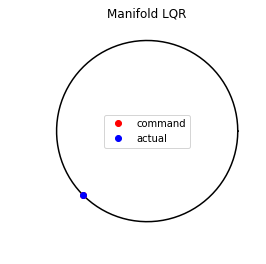

In [4]:
class LQR_Manifold:
    def __init__(self, Q, R):
        self.name = "Manifold LQR"

        self.Q = Q
        self.R = R
        self.b = 0.1
        self.I = 1.0
        self.A = np.array([[0, 1],[0, -self.b/self.I]])
        self.B = np.array([[0],[1/self.I]])
        self.tau_c = 0.0
        self.omega_c = 0.0
        self.manifold = True
        self.K = lqr(self.A, self.B, self.Q, self.R)

    def run(self, theta_c, theta, omega):
        Phi_tilde = SO2.vee(SO2.log(theta_c.inverse().dot(theta)))
        omega_tilde = omega - self.omega_c
        xt = np.array([[Phi_tilde, omega_tilde]]).T
        tau_tilde = -self.K.dot(xt)[0,0]    
        tau = tau_tilde + self.tau_c
        return tau

Q = np.eye(2) * np.array([10.0, 1.0])
R = np.array([[0.1]])
sim = Simulator(LQR_Manifold(Q=Q, R=R), commands=[3*np.pi/4, -3*np.pi/4])
HTML(sim.animate().to_html5_video())

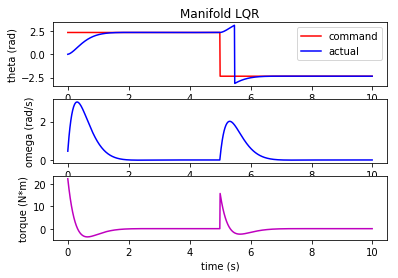

In [5]:
sim.plot()

### LQR with Input Saturation

LQR is a really powerful controller, but it has some shortcomings. The most obvious being the inability to include path constraints - such as a maximum torque. Let us assume that we have some maximum torque on our motor - let's see what happens if we simply saturate the LQR Controller to 10 Newtons

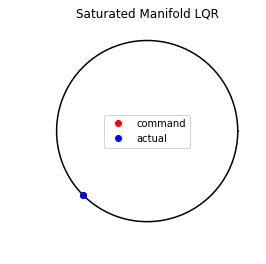

In [6]:
class LQR_Manifold_Saturated(LQR_Manifold): 
    def __init__(self, Q, R):
        LQR_Manifold.__init__(self,Q,R)
        self.name = "Saturated Manifold LQR"

    def run(self, theta_c, theta, omega):
        u = LQR_Manifold.run(self, theta_c, theta, omega)
        if u > 10: u = 10
        elif u < -10: u = -10
        return u

Q = np.eye(2) * np.array([10.0, 1.0])
R = np.array([[0.1]])
sim = Simulator(LQR_Manifold_Saturated(Q=Q, R=R), commands=[3*np.pi/4, -3*np.pi/4])
HTML(sim.animate().to_html5_video())

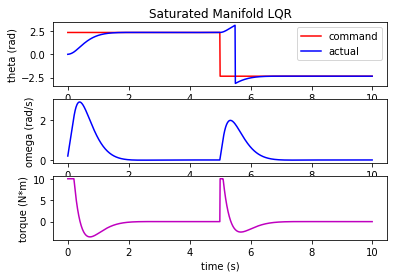

In [7]:
sim.plot()

## Linear Model Predictive Control
In this case, there are actually no obvious drawbacks to performing saturation, however on more complicated systems saturation can cause major problems.  To get around these, let us look at performing linear model-predictive control (LMPC).

In our case, we will seek to solve the following optimization problem

$\newcommand{norm}[1]{\left\lVert#1\right\rVert}$

\begin{eqnarray}
\min_\ut & & \sum_{k=0}^{N-1} \xt[k]^\top \Q \xt[k] + \ut[k]^\top \R \u[k] \nonumber \\
s.t.:& & -10 \leq \u[k] \leq 10 \quad k = 0, \ldots, N-1 \nonumber \\
     & & \xt[k+1] = \A\xt[k] + \B\ut[k] \quad k=0, \ldots, N-1 \nonumber \\
     & & x[0] = x_0 \nonumber
\label{eq:cost_function}
\end{eqnarray}

This is actually relatively easy to implement with the Python Convex Optimization Library `cvxpy`.

IndexError: Too many indices for expression.

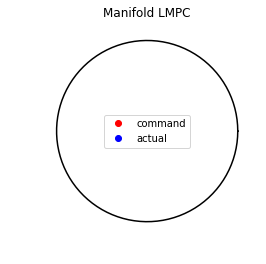

In [8]:
import cvxpy
class LMPC_Manifold:
    def __init__(self, Q, R):
        self.name = "Manifold LMPC"

        self.Q = Q
        self.R = R
        self.b = 0.1
        self.I = 1.0
        self.A = np.array([[0, 1],[0, -self.b/self.I]])
        self.B = np.array([[0],[1/self.I]])
        self.tau_c = 0.0
        self.omega_c = 0.0
        self.manifold = True
        self.N = 25

    def run(self, theta_c, theta, omega):
        x = cvxpy.Variable(2, self.N+1)
        u = cvxpy.Variable(1, self.N)
           
        Phi_tilde = SO2.vee(SO2.log(theta_c.inverse().dot(theta)))
        omega_tilde = omega - self.omega_c
        xt0 = np.array([[Phi_tilde, omega_tilde]]).T
        
        cost = 0.0
        constr = []
        for k in range(self.N):
            cost += cvxpy.quad_form(x[:,k], self.Q)
            cost += cvxpy.quad_form(u[:,k], self.R)
            constr.append(x[:,k+1] == x[:,k] + 0.01*(self.A * x[:,k] + self.B*u[:,k]))
            constr += [u[:,k] < 10]
            constr += [u[:,k] > -10]
        constr += [x[:,0] == xt0]
        prob = cvxpy.Problem(cvxpy.Minimize(cost), constr)
        prob.solve(verbose=False)
        
        tau_tilde = np.array(u.value)[0,0]  
        tau = tau_tilde + self.tau_c
        return tau

Q = np.eye(2) * np.array([10.0, 1.0])
R = np.array([[0.1]])
# Watch out - this takes about 4 minutes on my i7 laptop
sim = Simulator(LMPC_Manifold(Q=Q, R=R), commands=[3*np.pi/4, -3*np.pi/4])
HTML(sim.animate().to_html5_video())

In [ ]:
sim.plot()

While this worked, there are some obvious drawbacks to this implementation - the largest being the absurd computational requirements. Running the above examples takes about 4 minutes on my i7 laptop, whereas the saturated LQR controller takes 14 seconds. Other drawbacks include the linearization requirement, however MPC allows you to be very flexible with your modeling and constraint design which is often necessary for real-world performance.
